*First compiled: June 19, 2017.*

# Graph abstraction for minimal examples

In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as pl
import scanpy.api as sc
sc.settings.verbosity = 1                          # verbosity: 0=errors, 1=warnings, 2=info, 3=hints, ...
sc.settings.set_figure_params(dpi=80)              # dots (pixels) per inch determine size of inline figures
sc.logging.print_version_and_date()

Running Scanpy version 0.2.8+18.g1b7c77c.dirty on 2017-09-26 22:33.


The notebooks contains the following sections.
* Section 1: [Simulated data for myeloid progenitor development](#data1)  
* Section 2: [Simulated data for different degrees of clustering](#data2)

## Simulated data for myeloid progenitor development <a id="data1"></a>

The simulated data describes development from a progenitor cell to four differentiated cell types: monocyte, erythrocyte, megacaryocyte and neutrophil.

See [Krumsiek *et al.* (2009)](https://doi.org/10.1371/journal.pone.0022649) for the definition of the boolean literature-curated network underlying the simulation and discussion of marker genes. The data has been generated using `sc.tl.sim('krumsiek11')`; see [here](https://github.com/theislab/scanpy_usage/tree/master/170430_krumsiek11) for more details. We add some clusters to the data, sampled from a Gaussian mixture model.

In [2]:
adata_krumsiek11 = sc.datasets.krumsiek11()
X_blobs = sc.datasets.blobs(cluster_std=0.5, n_centers=2).X
X_concatenated = np.r_[adata_krumsiek11.X, X_blobs]
adata = sc.AnnData(X_concatenated)
adata.var_names = adata_krumsiek11.var_names
adata.add = adata_krumsiek11.add

reading ./write/data/Users/alexwolf/hholtz/01_projects/1512_scanpy/scanpy/scanpy/datasets/krumsiek11.h5


Annotate the timeseries plot for Scanpy's simulation tool.

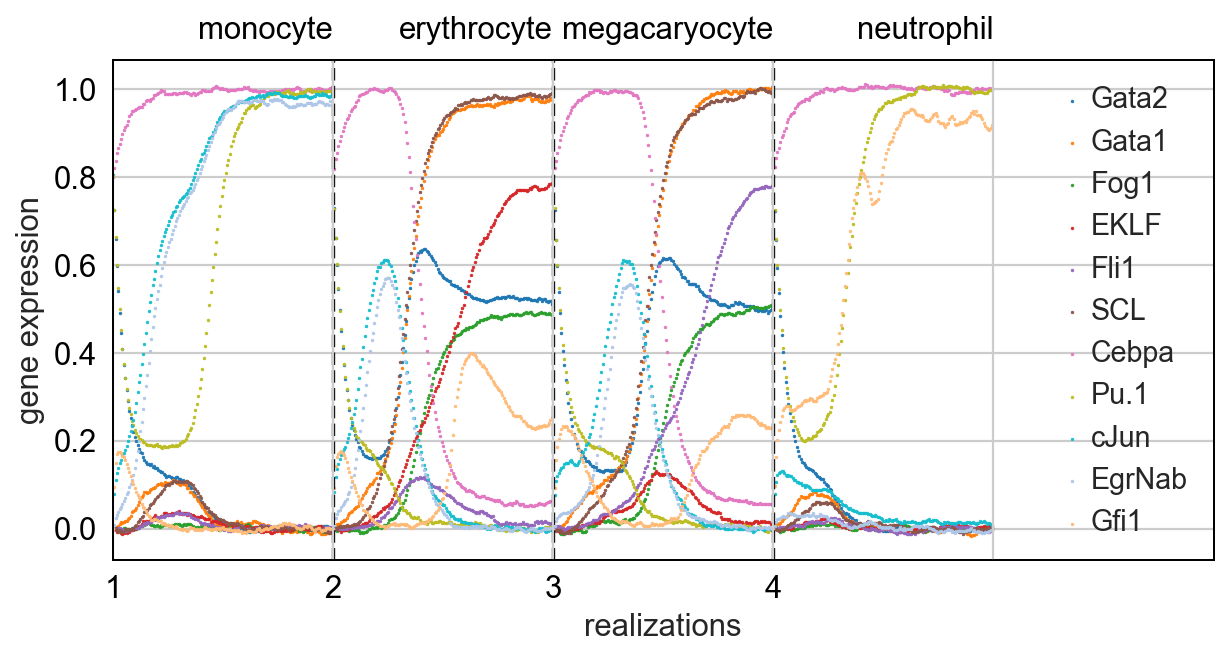

In [31]:
sc.pl.sim(adata_krumsiek11, tmax_realization=160, show=False)
xlim = pl.xlim()
pl.twiny()
pl.xlim(pl.xlim(xlim))
pl.xticks(np.arange(160, 5*160, 160),                                                                                                                           
          ['monocyte', 'erythrocyte', 'megacaryocyte', 'neutrophil'], ha='right')
pl.savefig('./figures/krumsiek11_timeseries.png', dpi=300)
pl.show()

Plot the same thing as heatmaps.

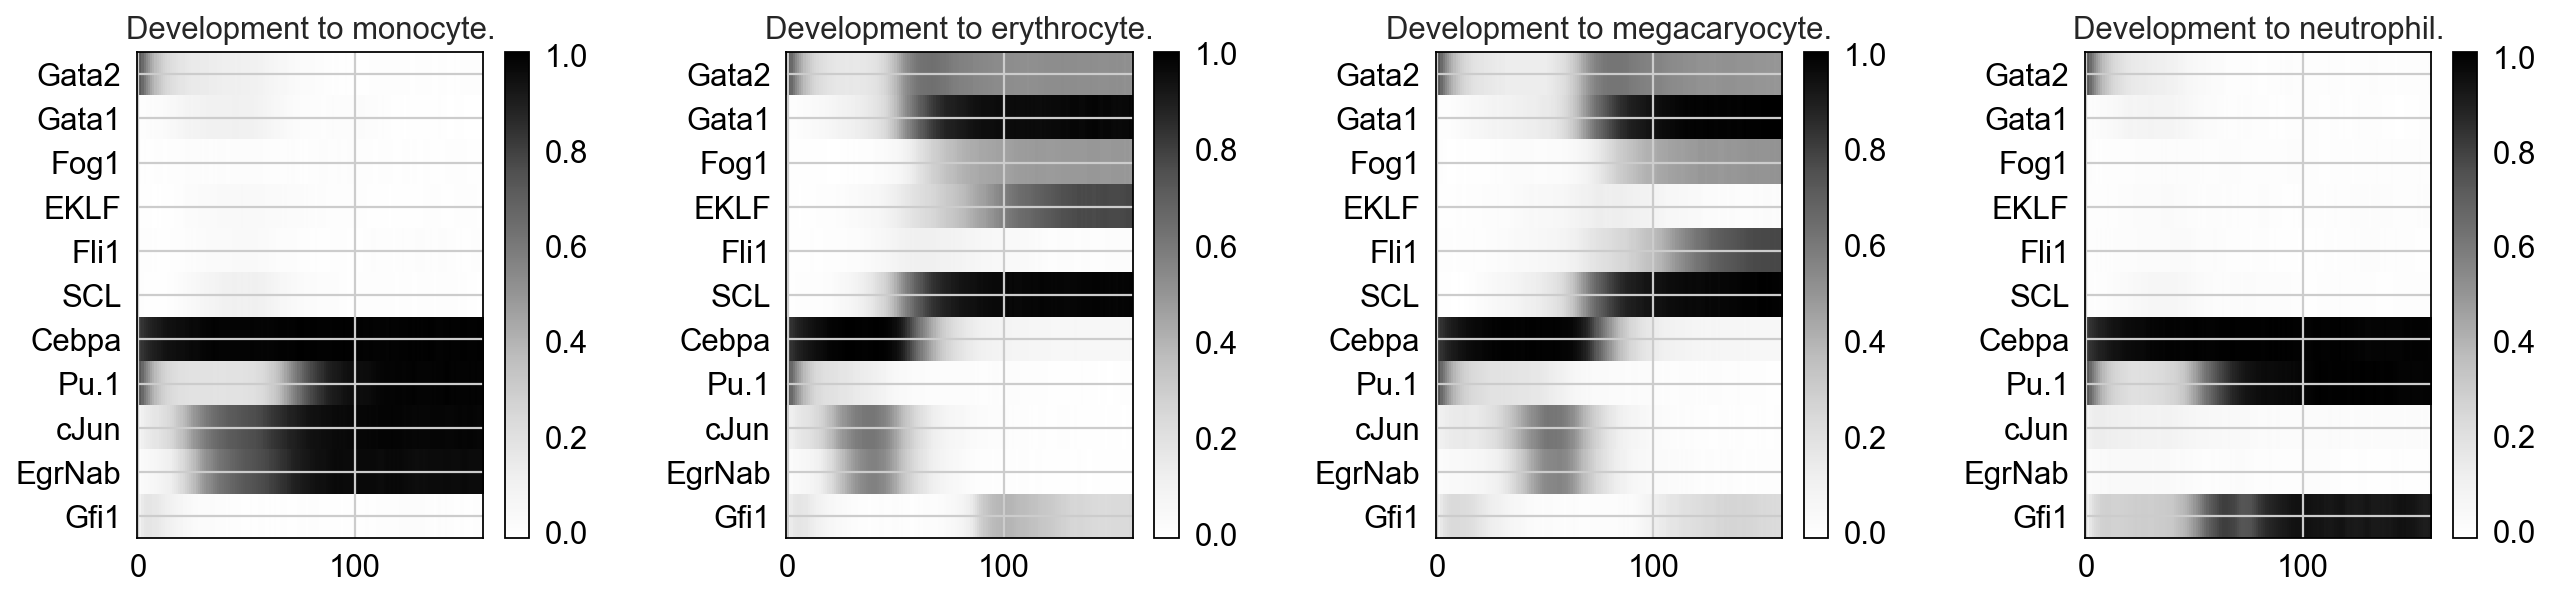

In [32]:
_, axs = pl.subplots(ncols=4, figsize=(16, 4), gridspec_kw={'wspace': 0.5})
pl.subplots_adjust(left=0.05, right=0.98)
imin = 0
for ititle, title in enumerate(['monocyte', 'erythrocyte', 'megacaryocyte', 'neutrophil']):
    pl.sca(axs[ititle])
    img = pl.imshow(adata.X[imin:imin+160].T, aspect='auto', interpolation='nearest')
    pl.yticks(range(adata.n_vars), adata.var_names)
    pl.title('Development to {}.'.format(title))
    pl.colorbar(img)
    imin += 160
pl.savefig('./figures/krumsiek11_timeseries_heatmap.png', dpi=300)    
pl.show()

### Visualization

In [3]:
sc.tl.tsne(adata)
sc.tl.draw_graph(adata, random_state=5)  # random_state just makes a cosmetic change
sc.write('krumsiek11_blobs', adata)

writing ./write/krumsiek11_blobs.h5


reading ./write/krumsiek11_blobs.h5
saving figure to file ./figures/tsne.png


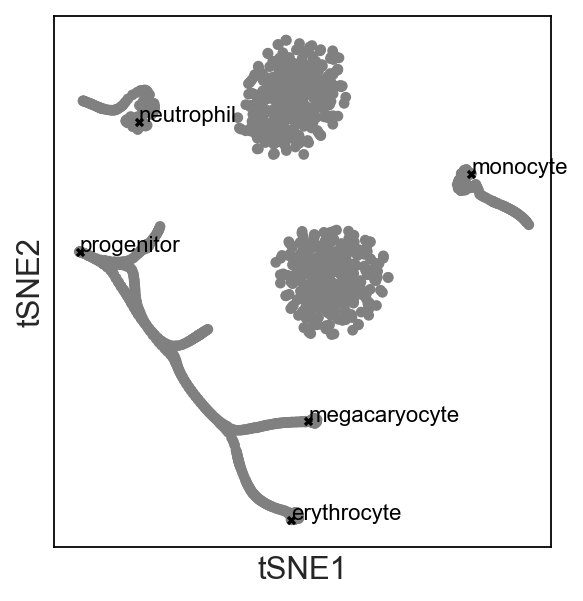

In [2]:
adata = sc.read('krumsiek11_blobs')
ax = sc.pl.tsne(adata, save=True)

saving figure to file ./figures/draw_graph_fr.png


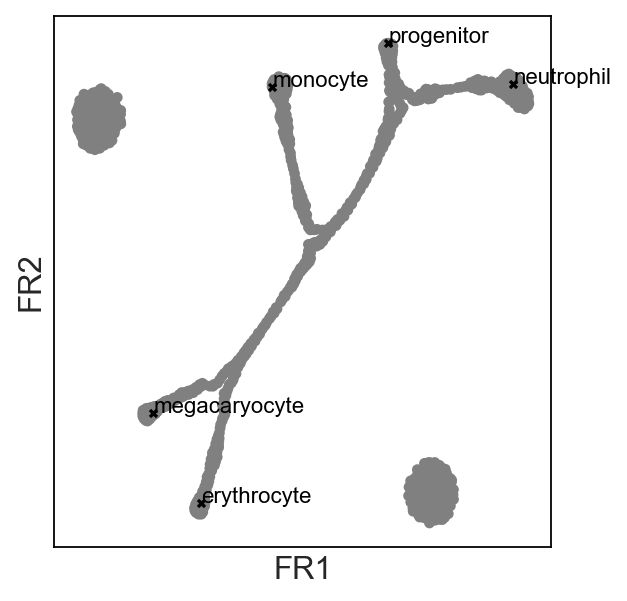

In [3]:
ax = sc.pl.draw_graph(adata, save=True)

### Construct the abstracted graph

In [6]:
adata = sc.read('krumsiek11_blobs')
sc.tl.aga(adata, resolution=2.5)

reading ./write/krumsiek11_blobs.h5


saving figure to file ./figures/aga.png


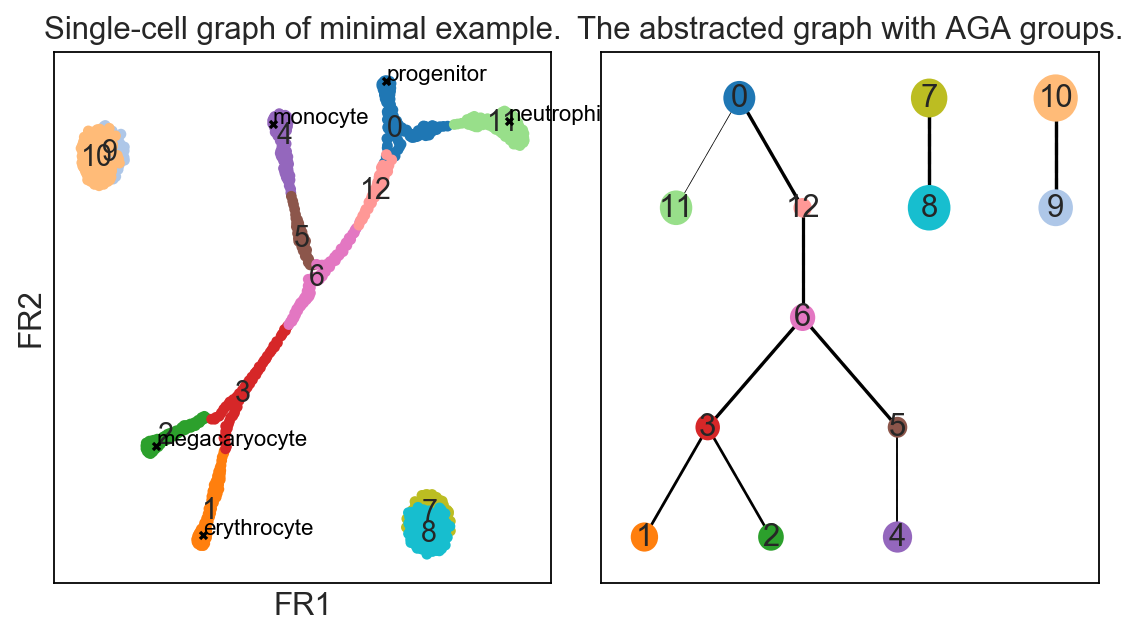

In [7]:
axs = sc.pl.aga(adata, basis='draw_graph_fr', color='aga_groups', groups_graph='aga_groups',
                title='Single-cell graph of minimal example.', save=True,
                root=[0, 7, 10], layout='rt', frameon=True,
                title_graph='The abstracted graph with AGA groups.')

In [26]:
sc.write('krumsiek11_blobs', adata)

Export this for external reusage.

In [ ]:
sc.write('krumsiek11_blobs', adata, ext='csv')

### Gene dynamics along paths

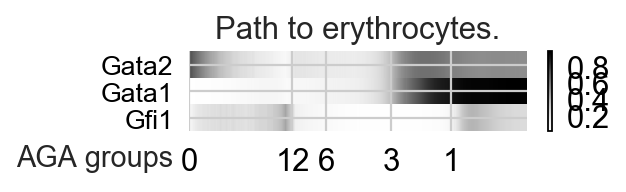

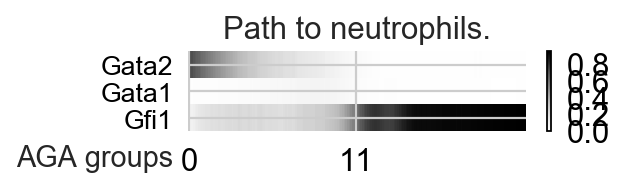

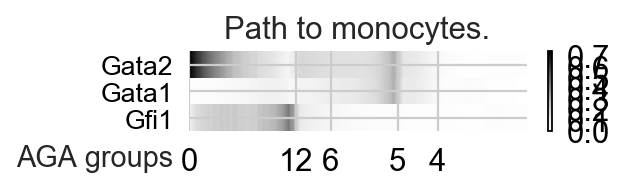

In [2]:
adata = sc.read('krumsiek11_blobs')
paths = [('erythrocytes', [0, 12, 6, 3, 1]),
         ('neutrophils', [0, 11]),
         ('monocytes', [0, 12, 6, 5, 4])]
rcParams['figure.figsize'] = (4, 1)
rcParams['figure.subplot.top'] = 0.75
rcParams['figure.subplot.bottom'] = 0.25
for ipath, (descr, path) in enumerate(paths):
    ax = sc.pl.aga_path(adata, left_margin=0.3,
                        nodes=path,
                        keys=['Gata2', 'Gata1', 'Gfi1'],
                        n_avg=10,
                        ytick_fontsize=12,
                        title='Path to {}.'.format(descr),
                        show=False)
    pl.savefig('./figures/aga_path_{}.png'.format(descr))
    pl.show()    
sc.pl.reset_rcParams()

## Simulated data for different degrees of clustering <a id="data2"></a>

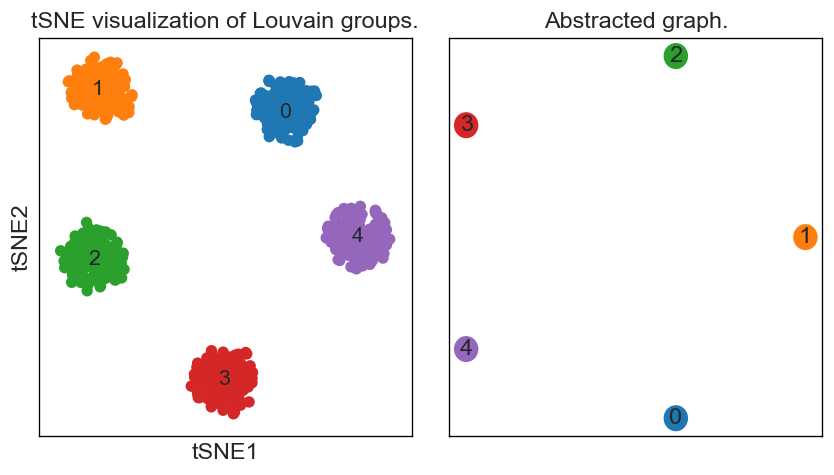

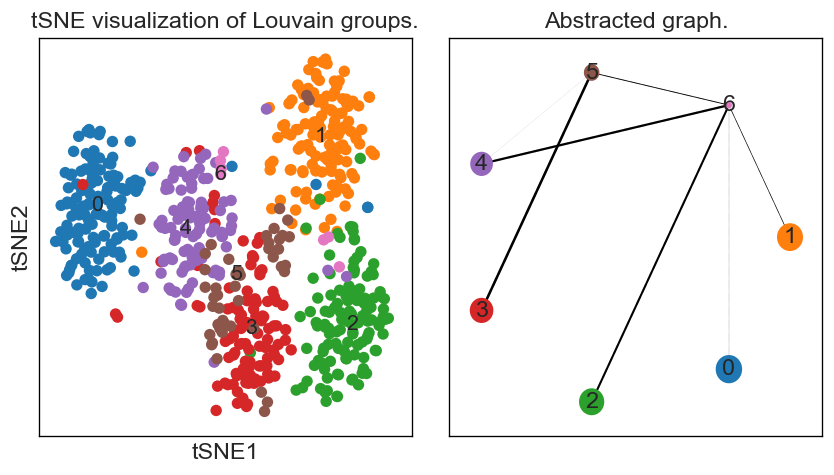

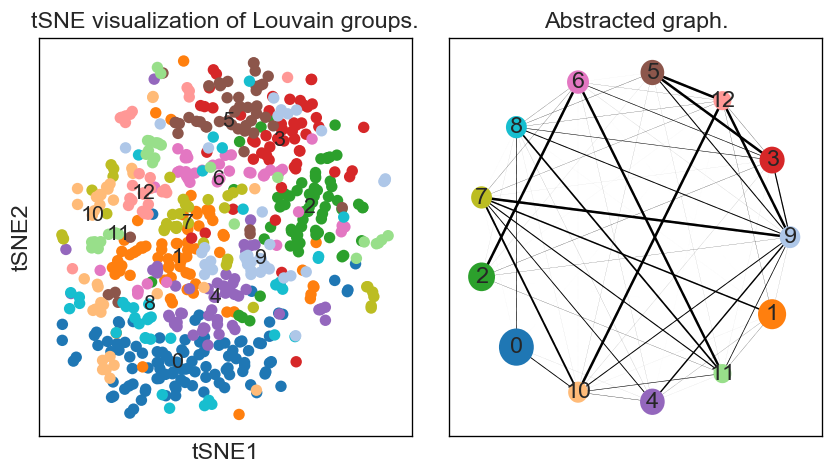

In [8]:
sc.settings.verbosity = 1
sc.settings.set_dpi(60)
for std in [1, 6, 10]:
    adata = sc.examples.blobs(cluster_std=std, n_centers=5)
    sc.tl.tsne(adata)
    sc.tl.aga(adata, n_neighbors=5, tree_based_confidence=False)
    sc.pl.aga(adata, solid_edges='aga_adjacency_full_confidence', layout='circle', frameon=True,
              title='tSNE visualization of Louvain groups.',
              title_graph='Abstracted graph.',
              save='_cluster_std{}'.format(std), show=True)